In [245]:
import tensorflow as tf
import numpy as np
import random
import pandas as pd
import nltk
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from transformers import TFAutoModel, AutoTokenizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import (
    Input, Dense, Dropout, GlobalMaxPooling1D, GlobalAveragePooling1D, 
    BatchNormalization, Concatenate, Bidirectional, LSTM, Lambda
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# ✅ Enable Mixed Precision Training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# ✅ Load ParsBERT Model & Tokenizer
model_name = "HooshvareLab/bert-base-parsbert-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# ✅ Define max length for tokenization
max_length = 96  

# ✅ Function to tokenize texts
def tokenize_data(texts, labels):
    encodings = tokenizer(
        texts, 
        truncation=True, 
        padding="max_length",
        max_length=max_length, 
        return_tensors="tf"
    )
    labels = tf.convert_to_tensor(labels, dtype=tf.int32)
    
    return tf.data.Dataset.from_tensor_slices((dict(encodings), labels)).shuffle(1000).batch(16).prefetch(tf.data.experimental.AUTOTUNE)

# ✅ Data Augmentation with Synonym Replacement
def synonym_replacement(sentence, n=2):
    words = sentence.split()
    new_words = words.copy()
    random.shuffle(new_words)
    num_replaced = 0
    for word in new_words:
        if num_replaced >= n:
            break
        synonyms = wordnet.synsets(word)
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name()
            if synonym != word:
                new_words = [synonym if w == word else w for w in new_words]
                num_replaced += 1
    return ' '.join(new_words)

# ✅ Word Dropout Augmentation
def word_dropout(sentence, p=0.1):
    words = sentence.split()
    new_words = [word for word in words if random.random() > p]
    return ' '.join(new_words) if new_words else sentence

# ✅ Load dataset
data_path = "Dataset_with_span_and_target.csv"
df = pd.read_csv(data_path)
texts, labels = df["text"].tolist(), df["HateSpeech"].tolist()

# ✅ Apply Data Augmentation (Synonym Replacement & Dropout)
augmented_texts, augmented_labels = [], []
for text, label in zip(texts, labels):
    if random.random() < 0.5:  
        augmented_texts.append(synonym_replacement(text))
        augmented_labels.append(label)
    if random.random() < 0.5:
        augmented_texts.append(word_dropout(text))
        augmented_labels.append(label)

texts += augmented_texts
labels += augmented_labels

# ✅ Balance Dataset Using Oversampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
texts, labels = ros.fit_resample(np.array(texts).reshape(-1, 1), np.array(labels))
texts = texts.flatten().tolist()

# ✅ Split Data (Train: 80%, Val: 20%)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, 
    test_size=0.2, 
    random_state=42, 
    stratify=labels  
)

# ✅ Tokenize Data
train_dataset = tokenize_data(train_texts, train_labels)
val_dataset = tokenize_data(val_texts, val_labels)

# ✅ Define Model with BiLSTM + ParsBERT
def build_model(dropout_rate, learning_rate, hidden_units, l2_lambda):
    bert_model = TFAutoModel.from_pretrained(model_name)

    input_ids = Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")

    def bert_function(inputs):
        input_ids, attention_mask = inputs
        return bert_model(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)['last_hidden_state']

    bert_output = Lambda(bert_function, output_shape=(max_length, 768))([input_ids, attention_mask])

    # ✅ Use BiLSTM to improve context understanding
    lstm_output = Bidirectional(LSTM(128, return_sequences=True))(bert_output)

    # ✅ Combine GlobalMaxPooling and GlobalAveragePooling
    max_pool = GlobalMaxPooling1D()(lstm_output)
    avg_pool = GlobalAveragePooling1D()(lstm_output)
    pooled_output = Concatenate()([max_pool, avg_pool])

    # ✅ Apply Batch Normalization & Dropout
    x = Dense(hidden_units, activation="relu", kernel_regularizer=l2(l2_lambda))(pooled_output)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    # ✅ Output Layer (Binary classification)
    output = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=[input_ids, attention_mask], outputs=output)

    # ✅ Learning Rate Decay
    lr_schedule = ExponentialDecay(
        initial_learning_rate=learning_rate,
        decay_steps=1000,
        decay_rate=0.9,
        staircase=True
    )

    # ✅ Use AdamW Optimizer
    optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_schedule, clipnorm=1.0)

    # ✅ Compile Model
    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

# ✅ Optimized Hyperparameters
best_hps = {
    "dropout_rate": 0.5,  
    "learning_rate": 3e-5,  
    "hidden_units": 768,  
    "l2_lambda": 0.002  
}

# ✅ Train the Model
best_model = build_model(
    dropout_rate=best_hps["dropout_rate"],
    learning_rate=best_hps["learning_rate"],
    hidden_units=best_hps["hidden_units"],
    l2_lambda=best_hps["l2_lambda"]
)

# ✅ Define Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_parsbert_bilstm_model.h5", save_best_only=True, monitor='val_loss', mode='min')

# ✅ Train Model
history = best_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,  
    callbacks=[early_stopping, model_checkpoint]
)

# ✅ Evaluate Model
test_loss, test_accuracy = best_model.evaluate(val_dataset)
print(f"Final Test Accuracy: {test_accuracy:.4f}")

Some layers from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 774ms/step - accuracy: 0.6279 - loss: 1.9331

1039/1039 ━━━━━━━━━━━━━━━━━━━━ 997s 956ms/step - accuracy: 0.6280 - loss: 1.9330 - val_accuracy: 0.7629 - val_loss: 1.6118
Epoch 2/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - accuracy: 0.7419 - loss: 1.6503

1039/1039 ━━━━━━━━━━━━━━━━━━━━ 1045s 1s/step - accuracy: 0.7419 - loss: 1.6502 - val_accuracy: 0.7894 - val_loss: 1.4984
Epoch 3/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 829ms/step - accuracy: 0.7820 - loss: 1.4974

1039/1039 ━━━━━━━━━━━━━━━━━━━━ 1053s 1s/step - accuracy: 0.7820 - loss: 1.4974 - val_accuracy: 0.8170 - val_loss: 1.3982
Epoch 4/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 826ms/step - accuracy: 0.8087 - loss: 1.3867

1039/1039 ━━━━━━━━━━━━━━━━━━━━ 1046s 1s/step - accuracy: 0.8087 - loss: 1.3867 - val_accuracy: 0.8293 - val_loss: 1.3208
Epoch 5/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - accuracy: 0.8334 - loss: 1.3026

1039/1039 ━━━━━━━━━━━━━━━━━━━━ 990s 953ms/step - accuracy: 0.8334 - loss: 1.3026 - val_accuracy: 0.8411 - val_loss: 1.2476
Epoch 6/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - accuracy: 0.8660 - loss: 1.1964

1039/1039 ━━━━━━━━━━━━━━━━━━━━ 994s 957ms/step - accuracy: 0.8660 - loss: 1.1964 - val_accuracy: 0.8584 - val_loss: 1.1867
Epoch 7/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.8864 - loss: 1.1250

1039/1039 ━━━━━━━━━━━━━━━━━━━━ 1001s 964ms/step - accuracy: 0.8864 - loss: 1.1250 - val_accuracy: 0.8683 - val_loss: 1.1419
Epoch 8/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 780ms/step - accuracy: 0.9042 - loss: 1.0506

1039/1039 ━━━━━━━━━━━━━━━━━━━━ 991s 953ms/step - accuracy: 0.9042 - loss: 1.0506 - val_accuracy: 0.8777 - val_loss: 1.0973
Epoch 9/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 786ms/step - accuracy: 0.9145 - loss: 0.9940

1039/1039 ━━━━━━━━━━━━━━━━━━━━ 1000s 962ms/step - accuracy: 0.9145 - loss: 0.9939 - val_accuracy: 0.8871 - val_loss: 1.0501
Epoch 10/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 795ms/step - accuracy: 0.9353 - loss: 0.9301

1039/1039 ━━━━━━━━━━━━━━━━━━━━ 1008s 970ms/step - accuracy: 0.9353 - loss: 0.9301 - val_accuracy: 0.8946 - val_loss: 1.0133
Epoch 11/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - accuracy: 0.9430 - loss: 0.8838

1039/1039 ━━━━━━━━━━━━━━━━━━━━ 994s 957ms/step - accuracy: 0.9430 - loss: 0.8838 - val_accuracy: 0.8938 - val_loss: 0.9890
Epoch 12/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 799ms/step - accuracy: 0.9555 - loss: 0.8433

1039/1039 ━━━━━━━━━━━━━━━━━━━━ 1013s 975ms/step - accuracy: 0.9555 - loss: 0.8433 - val_accuracy: 0.9011 - val_loss: 0.9613
Epoch 13/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - accuracy: 0.9551 - loss: 0.8124

1039/1039 ━━━━━━━━━━━━━━━━━━━━ 1040s 1s/step - accuracy: 0.9551 - loss: 0.8124 - val_accuracy: 0.9027 - val_loss: 0.9452
Epoch 14/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 839ms/step - accuracy: 0.9645 - loss: 0.7765

1039/1039 ━━━━━━━━━━━━━━━━━━━━ 1064s 1s/step - accuracy: 0.9645 - loss: 0.7765 - val_accuracy: 0.9056 - val_loss: 0.9346
Epoch 15/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 842ms/step - accuracy: 0.9639 - loss: 0.7521

1039/1039 ━━━━━━━━━━━━━━━━━━━━ 1067s 1s/step - accuracy: 0.9639 - loss: 0.7521 - val_accuracy: 0.9059 - val_loss: 0.9082
Epoch 16/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 840ms/step - accuracy: 0.9737 - loss: 0.7168

1039/1039 ━━━━━━━━━━━━━━━━━━━━ 1056s 1s/step - accuracy: 0.9737 - loss: 0.7168 - val_accuracy: 0.9073 - val_loss: 0.8958
Epoch 17/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 807ms/step - accuracy: 0.9803 - loss: 0.6897

1039/1039 ━━━━━━━━━━━━━━━━━━━━ 1022s 984ms/step - accuracy: 0.9803 - loss: 0.6897 - val_accuracy: 0.9097 - val_loss: 0.8817
Epoch 18/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 808ms/step - accuracy: 0.9815 - loss: 0.6690

1039/1039 ━━━━━━━━━━━━━━━━━━━━ 1023s 985ms/step - accuracy: 0.9815 - loss: 0.6690 - val_accuracy: 0.9078 - val_loss: 0.8726
Epoch 19/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 809ms/step - accuracy: 0.9837 - loss: 0.6512

1039/1039 ━━━━━━━━━━━━━━━━━━━━ 1029s 990ms/step - accuracy: 0.9837 - loss: 0.6512 - val_accuracy: 0.9133 - val_loss: 0.8489
Epoch 20/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 1030s 991ms/step - accuracy: 0.9828 - loss: 0.6385 - val_accuracy: 0.9090 - val_loss: 0.8604
260/260 ━━━━━━━━━━━━━━━━━━━━ 191s 733ms/step - accuracy: 0.9132 - loss: 0.8685
Final Test Accuracy: 0.9133


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

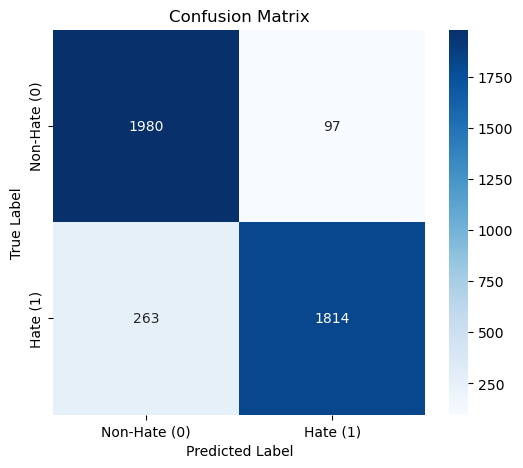

In [246]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Step 1: Get Predictions on Validation Data
y_true = []
y_pred_probs = []  # Store probabilities

for batch in val_dataset:
    inputs, labels = batch
    preds = best_model.predict(inputs)
    y_true.extend(labels.numpy())  # Convert tensor to numpy
    y_pred_probs.extend(preds.flatten())  # Flatten predictions

# ✅ Step 2: Convert Probabilities to Class Labels (Threshold = 0.5)
y_pred = np.array(y_pred_probs) >= 0.5  # Convert to 0/1

# ✅ Step 3: Print Classification Report
print("🔹 Final Test Accuracy:", np.mean(y_pred == y_true))  # Direct Accuracy Calculation
print("🔹 Classification Report:\n", classification_report(y_true, y_pred, digits=4))

# ✅ Step 4: Generate Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# ✅ Step 5: Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Non-Hate (0)", "Hate (1)"], yticklabels=["Non-Hate (0)", "Hate (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

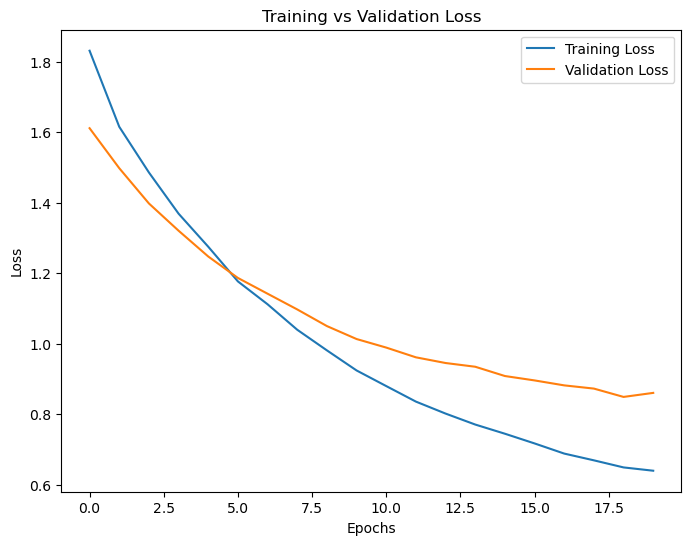

In [300]:
import matplotlib.pyplot as plt

# ✅ Plot Training and Validation Loss
def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.show()

plot_loss(history)

In [269]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# ✅ Get true labels and predicted probabilities
y_true = []
y_scores = []

for batch in val_dataset:  # Loop through the validation dataset
    inputs, labels = batch
    y_true.extend(labels.numpy())  # Convert tensor to numpy
    y_scores.extend(best_model.predict(inputs).flatten())  # Get predicted probabilities

y_true = np.array(y_true)  # Convert to numpy array
y_scores = np.array(y_scores)  # Convert to numpy array

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

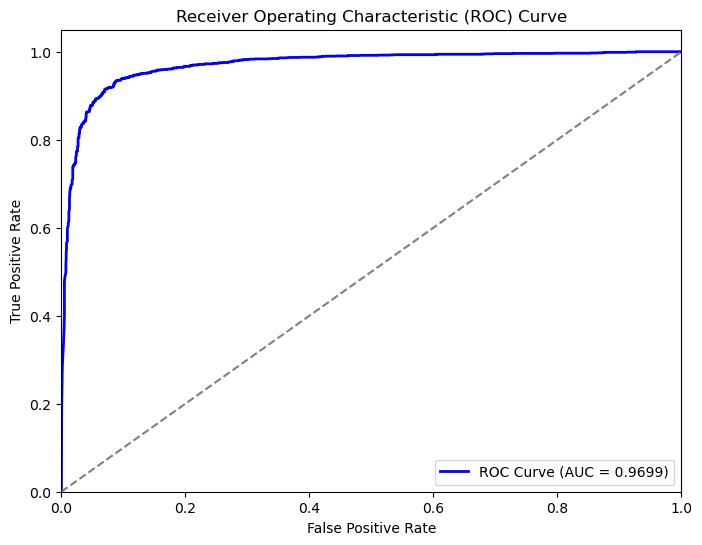

In [270]:
# ✅ Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# ✅ Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

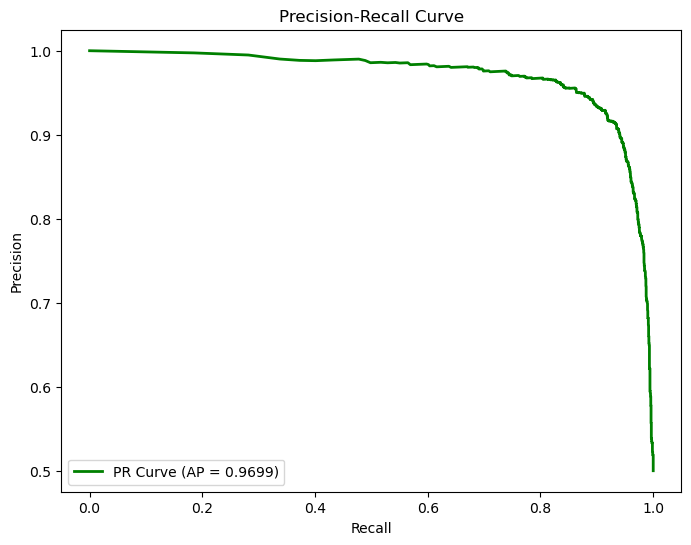

In [271]:
# ✅ Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_scores)
average_precision = average_precision_score(y_true, y_scores)

# ✅ Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2, label=f"PR Curve (AP = {average_precision:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()